In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import scrublet as scr
import seaborn as sns
import seaborn.objects as so


sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
    # color_map="YlGnBu",
    frameon=False,
)

In [2]:
# PP functions from Hwang et al.

def load_data(filename):
    adata = sc.read_10x_h5(filename)
    ncells, ngenes = adata.shape
    adata.var_names_make_unique()
    return adata

def basic_filter(adata):
    #sc.pp.filter_genes(adata, min_cells=3)
    sc.pp.filter_cells(adata, min_genes=0)
    adata.obs['n_counts'] = adata.X.sum(axis=1).A1
    #pdac_thresh_dict = load_umithreshold()
    #min_counts = pdac_thresh_dict.get(pid, 200)
    #adata = adata[adata.obs['n_counts'] >= min_counts]
    #adata = adata[adata.obs['n_counts'] <= 2500]
    return adata

def calculate_qc(adata, pid):    
    # compute the doublet scores
    scrub = scr.Scrublet(adata.X)
    doublet_scores, predicted_doublets = scrub.scrub_doublets()
    adata.obs['scrublet_scores'] = doublet_scores
    adata.obs['pid'] = [pid]*adata.shape[0]
    
    #adata = adata[adata.obs['scrublet_scores'] <= 0.2]
    
    # calculate the saturation counts
    sc.pp.calculate_qc_metrics(adata, percent_top=(5, 10, 20, 50, 100, 200, 500), inplace=True)
    adata.obs['n_counts_sat'] = [1000]*adata.shape[0]
    adata.obs['n_counts_sat'] = np.min(adata.obs[['n_counts', 'n_counts_sat']], axis=1)
    adata.obs['n_genes_sat'] = [1000]*adata.shape[0]
    adata.obs['n_genes_sat'] = np.min(adata.obs[['n_genes', 'n_genes_sat']], axis=1)
    mito_genes = adata.var_names.str.startswith('MT-')
    adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
    
    return adata

def basic_plots(adata):
    sc.pl.highest_expr_genes(adata, n_top=20)
    sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'], jitter=0.4, multi_panel=True)
    sc.pl.scatter(adata, x='n_counts', y='percent_mito')
    sc.pl.scatter(adata, x='n_counts', y='n_genes')
    return adata

In [3]:
sample_name = 'EK-1867_12-045_AF_7_21_16_Baseline'

raw_count_f_i = '/Users/haochen/Desktop/prePOLAR/snRNAseq/raw_CR_outputs/EK-1867_12-045_AF_7_21_16_Baseline.cr.raw_feature_bc_matrix.h5'

adata = load_data(raw_count_f_i)

/Users/haochen/anaconda3/envs/scanpy/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [5]:
adata.X

<494107x36601 sparse matrix of type '<class 'numpy.float32'>'
	with 24880046 stored elements in Compressed Sparse Row format>

## Calculate QC metrics

In [4]:
# mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes.
adata.var["hb"] = adata.var_names.str.contains(("^HB[^(P)]"))

sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=(5, 10, 20, 50, 100, 200, 500), log1p=True
)

## QC for CellBender

In [5]:
total_counts_sorted = adata.obs['total_counts'].sort_values(ascending=False).reset_index()

In [6]:
total_counts_sorted

,index,total_counts
0,ACGTCAAAGACAAAGG-1,271747.0
1,TTCGAAGTCGGTTAAC-1,144713.0
2,GTGCTTCCAGTTCCCT-1,135626.0
3,CACAAACCATGGTAGG-1,95366.0
4,AGAGTGGGTCTTTCAT-1,90169.0
...,...,...
494102,GGTGCGTAGTCATGCT-1,0.0
494103,CGTCAGGGTCCAGTTA-1,0.0
494104,CGTCAGGGTCCAGTGC-1,0.0
494105,ACTGCTCTCTCGAGTA-1,0.0


In [19]:
x = np.log(total_counts_sorted.loc[total_counts_sorted['total_counts'] > 18].index )
y = np.log(total_counts_sorted.loc[total_counts_sorted['total_counts'] > 18]['total_counts'] )


/Users/haochen/anaconda3/envs/scanpy/lib/python3.10/site-packages/pandas/core/indexes/base.py:969: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*new_inputs, **kwargs)


In [20]:
dydx

array([-0.90906452, -0.15994177, -1.22418705, ...,  0.        ,
        0.        ,  0.        ])

<AxesSubplot: >

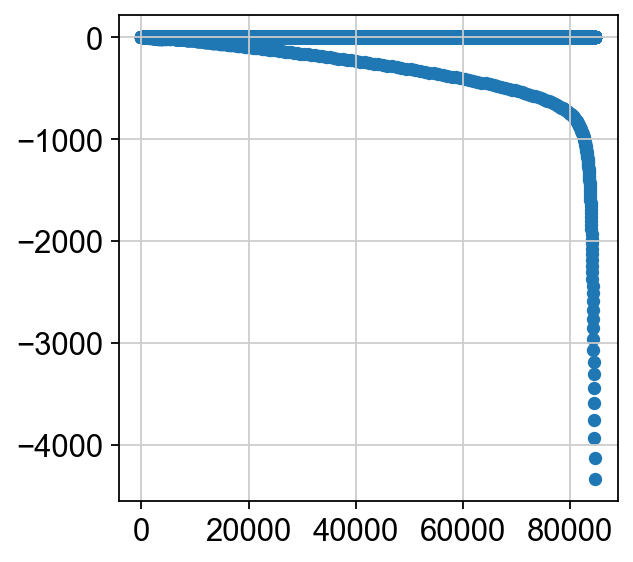

In [21]:
dydx = np.diff(y) / np.diff(x)

sns.scatterplot(x = range(len(dydx)), y = dydx, linewidth=0)

In [49]:
from kneed import KneeLocator

kneedle = KneeLocator(x, y, curve="concave", direction="decreasing", S=0)
print(round(kneedle.knee, 3))

8.126


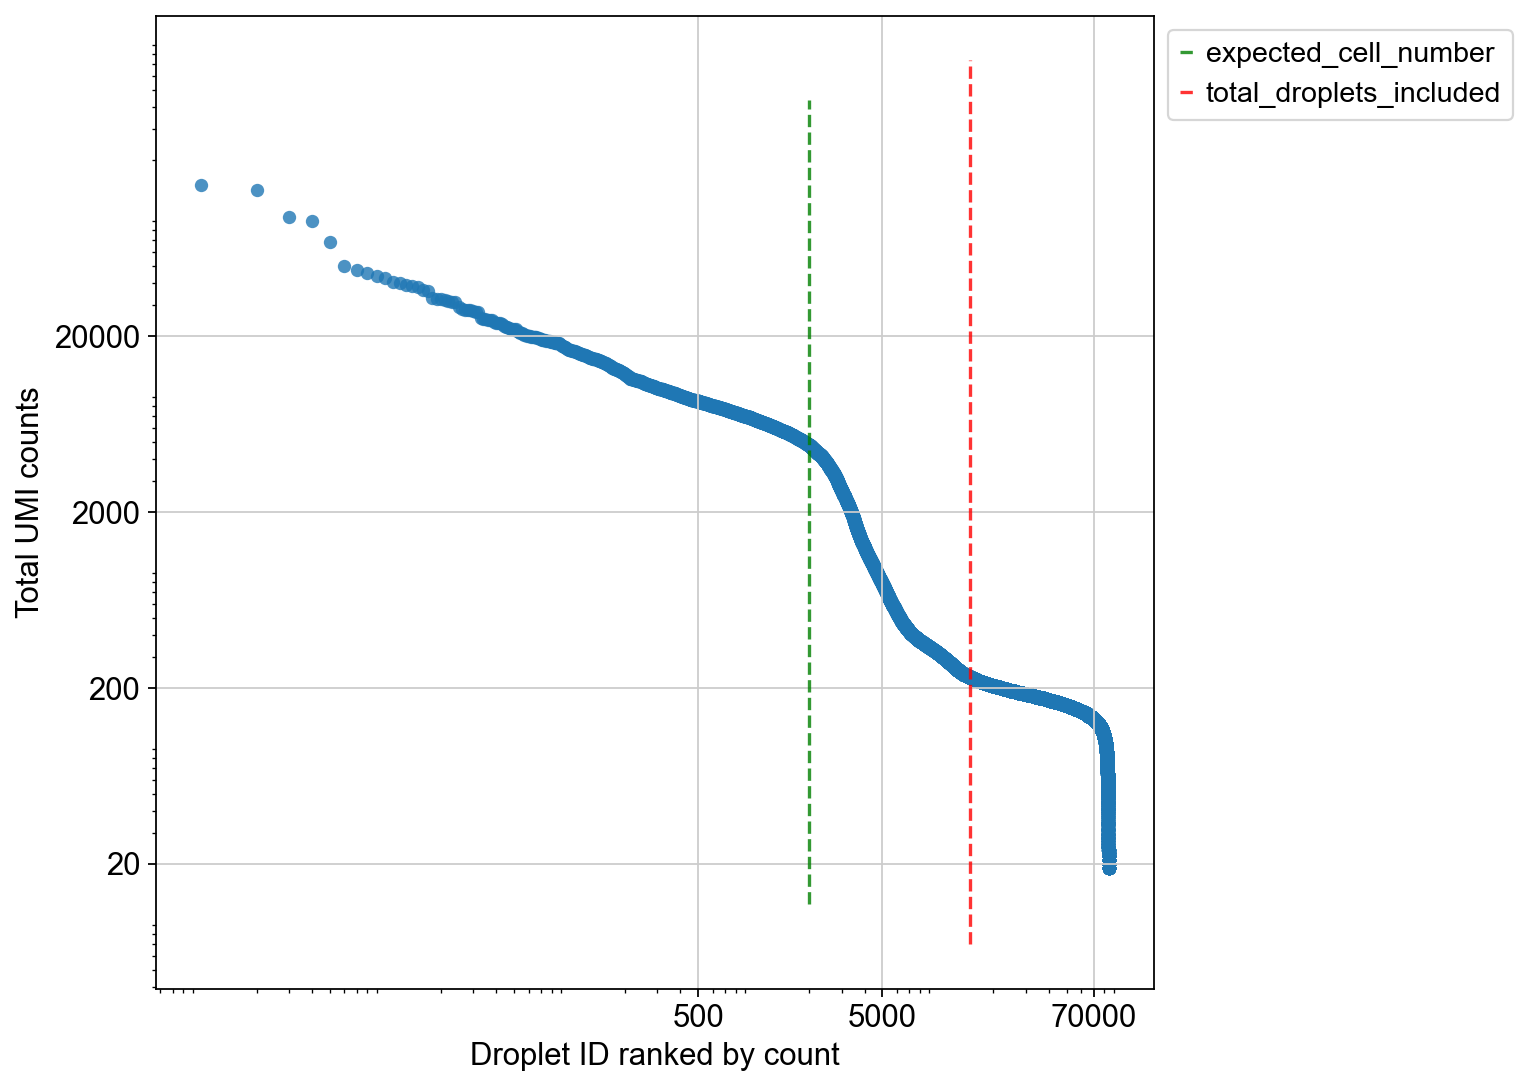

In [33]:
fig, ax = plt.subplots(figsize=(8, 8))

p0 = sns.scatterplot(
    x = total_counts_sorted.loc[total_counts_sorted['total_counts'] > 18].index, 
    y = total_counts_sorted.loc[total_counts_sorted['total_counts'] > 18]['total_counts'],
    alpha = 0.8, linewidth=0
    )
plt.xscale('log')
plt.yscale('log')

p0.set_xticks([500, 5000, 70000], [500, 5000, 70000])
p0.set_yticks([20,200,2000,20000], [20,200,2000,20000])

p0.set_xlabel('Droplet ID ranked by count')
p0.set_ylabel('Total UMI counts')

plt.vlines(2000, plt.ylim()[0], plt.ylim()[1], linestyles='dashed', color = 'green', alpha = 0.8, label = 'expected_cell_number')

plt.vlines(15000, plt.ylim()[0], plt.ylim()[1], linestyles='dashed', color = 'red', alpha = 0.8, label = 'total_droplets_included')

plt.legend(bbox_to_anchor = (1.0, 1), loc = 'upper left')
fig.savefig(f'{sample_name}-total_counts_sorted.png', dpi=200)

## QC 

In [55]:
total_counts_sorted

,index,total_counts
0,ACGTCAAAGACAAAGG-1,271747.0
1,TTCGAAGTCGGTTAAC-1,144713.0
2,GTGCTTCCAGTTCCCT-1,135626.0
3,CACAAACCATGGTAGG-1,95366.0
4,AGAGTGGGTCTTTCAT-1,90169.0
...,...,...
494102,GGTGCGTAGTCATGCT-1,0.0
494103,CGTCAGGGTCCAGTTA-1,0.0
494104,CGTCAGGGTCCAGTGC-1,0.0
494105,ACTGCTCTCTCGAGTA-1,0.0


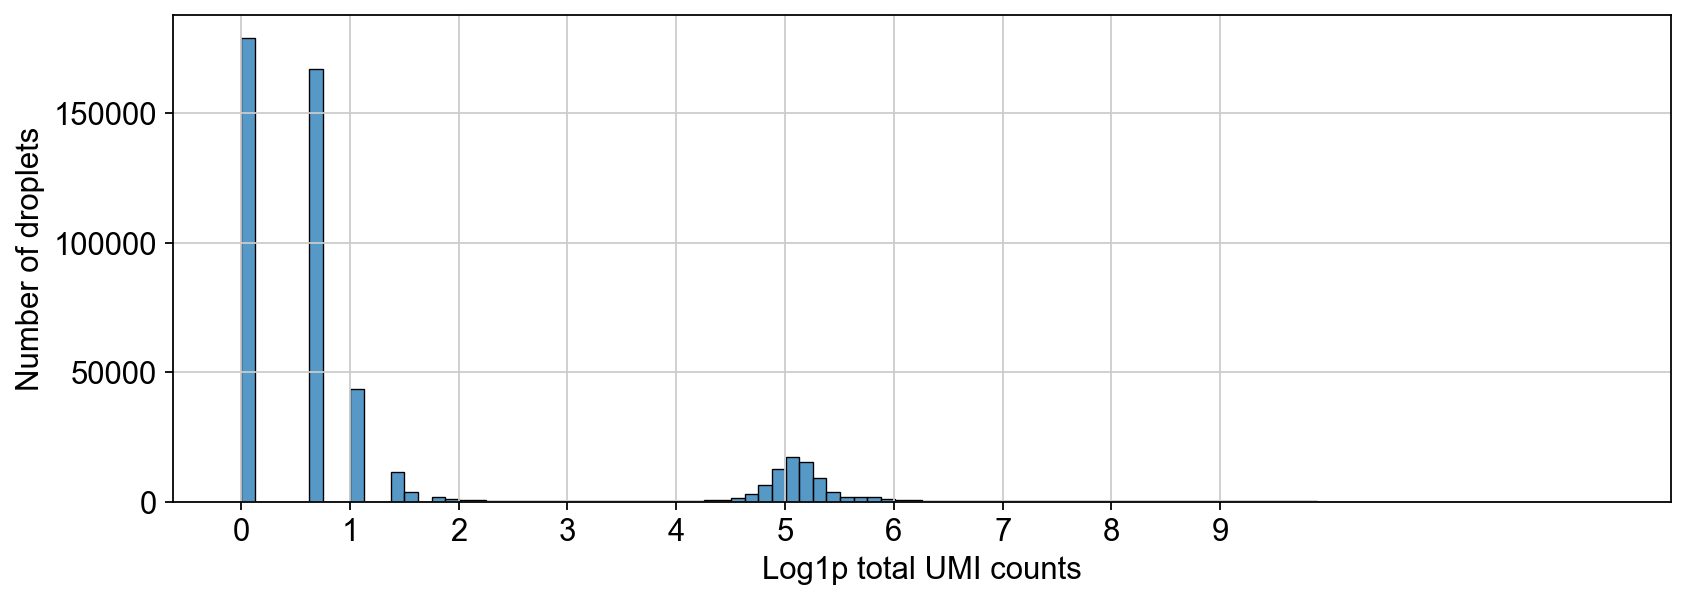

In [67]:
fig, ax = plt.subplots(figsize=(12, 4))

p1 = sns.histplot(ax=ax, data=np.log(total_counts_sorted['total_counts'] + 1), bins=100, kde=False)
p1.set_xlabel('Log1p total UMI counts')
p1.set_ylabel('Number of droplets')
p1.set_xticks(range(10), range(10))

plt.savefig('EK-1867_12-045_AF_7_21_16_Baseline_total_counts_hist.png', dpi=300)